In [2]:
import datetime
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import backend as K

from scipy import misc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from os import listdir
import os.path
import numpy as np
import string

now = datetime.datetime.now

data_dir = "data/Cropped_Words/COCO-Text-words-trainval"
training_dir = "/train_words/"
valid_dir = "/val_words/"

Using TensorFlow backend.


In [ ]:
def generate_vocab():    
    f = open(data_dir + '/train_words_gt.txt', 'r')
    labels = []
    for line in f.readlines():
        line = line.replace('|','')
        lab = line.split(',')
        if len(lab) >=2:            
            labels.append(lab[1])
            
    f = open(data_dir + '/val_words_gt.txt', 'r')    
    for line in f.readlines():
        line = line.replace('|','')
        lab = line.split(',')
        if len(lab) >=2:            
            labels.append(lab[1])
            
    vocab = list(set(labels))
    print("Unique vocabulary in the training and validation set is: {}".format(len(vocab)))
    return vocab

There are 42618 training images
There are 9896 validation images
Unique vocabulary in the training and validation set is: 29620
	Train data:  (42617, 32, 100, 1)
	Validation data:  (9896, 32, 100, 1)
	Train labels:  (42617,)
	Validation labels:  (9896,)


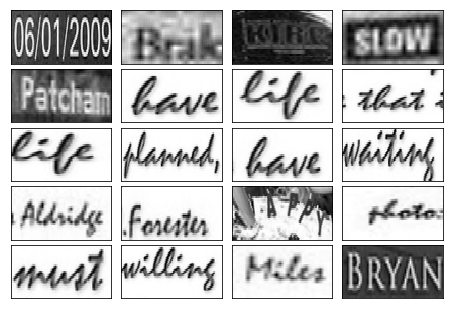

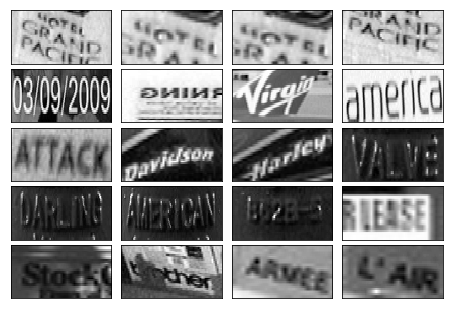

Saving the Data to data.npz
Data Saved to words.npz!


In [3]:
def load_data():
    train_files = listdir(data_dir + training_dir)
    val_files = listdir(data_dir + valid_dir)
    print("There are {} training images".format(len(train_files)))
    print("There are {} validation images".format(len(val_files)))
    
    vocab = generate_vocab()
    train_images=[]
    train_labels=[]
    valid_images=[]
    valid_labels=[]
    
    
    f = open(data_dir + '/train_words_gt.txt', 'r')  
    i =0
    for line in f.readlines():        
        i=i+1
        line = line.replace('|','')
        lab = line.split(',')
        if len(lab) >=2:  
            if not os.path.isfile(data_dir+training_dir+lab[0]+".jpg"):
                continue
            train_images.append(misc.imresize(misc.imread(data_dir+training_dir+lab[0]+".jpg", mode='L'), (32,100)))
            train_labels.append(vocab.index(lab[1]))
            
#         if i >20:
#             break            
    
    
    f = open(data_dir + '/val_words_gt.txt', 'r')  
    i =0
    for line in f.readlines():        
        i=i+1
        line = line.replace('|','')
        lab = line.split(',')
        if len(lab) >=2:  
            if not os.path.isfile(data_dir+valid_dir+lab[0]+".jpg"):
                continue
            valid_images.append(misc.imresize(misc.imread(data_dir+valid_dir+lab[0]+".jpg", mode='L'), (32,100)))
            valid_labels.append(vocab.index(lab[1]))
            
#         if i >20:
#             break 
    
    train_tensor = np.stack(train_images).astype("uint8")
    valid_tensor = np.stack(valid_images).astype("uint8")
    
    train_tensor = np.reshape(train_tensor, train_tensor.shape + (1,))
    valid_tensor = np.reshape(valid_tensor, valid_tensor.shape + (1,))
    
    train_label_dat = np.asarray(train_labels)
    valid_label_dat = np.asarray(valid_labels)
    
    print("\tTrain data: ", train_tensor.shape)
    print("\tValidation data: ", valid_tensor.shape)
    print("\tTrain labels: ", train_label_dat.shape)
    print("\tValidation labels: ", valid_label_dat.shape)  
    
    return (train_tensor, train_label_dat), (valid_tensor, valid_label_dat), vocab

(train_data, train_label), (valid_data, valid_label), vocab = load_data()

gs = gridspec.GridSpec(min(5,int(len(train_data)/4)),4, top=1., bottom=0., right=1., left=0., hspace=0.1, wspace=0.1)
    
for i,g in enumerate(gs): 
    ax = plt.subplot(g)
    ax.imshow(train_data[i,:,:,0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
plt.show()

for i,g in enumerate(gs): 
    ax = plt.subplot(g)
    ax.imshow(valid_data[i,:,:,0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
plt.show()

print("Saving the Data to data.npz")
np.savez('words.npz', train_data = train_data, train_label = train_label, valid_data = valid_data, valid_label = valid_label)
print("Data Saved to words.npz!")

In [11]:
npzfile = np.load('words.npz')
print (npzfile.files)
train_data = npzfile['train_data']
train_label= npzfile['train_label']
valid_dat= npzfile['valid_data']
valid_label = npzfile['valid_label']
vocab = generate_vocab()


def training_generator(batch_size, num_classes):
    while True:
        idx = np.random.randint(len(train_data), size = batch_size)
        x = train_data[idx,:]
        y = train_label[idx]
        x_train = x.astype('float32')
        x_train /= 255
        y_train = keras.utils.to_categorical(y, num_classes)        
        yield (x_train, y_train)
        
                                

def train_model(model, train, test, num_classes):
    x_train = train[0]
    x_test = test[0]
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    t = now()
    model.fit(x_train, y_train,
              batch_size=1000,
              epochs=4,
              verbose=1,
              validation_data=(x_test, y_test))
    print('Training time: %s' % (now() - t))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

network_layers = [
    ZeroPadding2D((1,1), input_shape=(32,100,1)),
    Conv2D(64, 5, activation='relu'),    
    MaxPooling2D(pool_size=(2,2)),
    ZeroPadding2D((1,1)),
    Conv2D(128, 5, activation='relu'),    
    MaxPooling2D(pool_size=(2,2), dim_ordering="th"),
    ZeroPadding2D((1,1)),
    Conv2D(256, 3, activation='relu'),    
    MaxPooling2D(pool_size=(2,2), dim_ordering="th"),
    ZeroPadding2D((1,1)),
    Conv2D(512, 3, activation='relu'),
    ZeroPadding2D((1,1)),
    Conv2D(512, 3, activation='relu'),    
    Flatten(),
    Dense(10, activation='relu'),   
    Dense(10, activation='relu'),  
    Dense(len(vocab), activation ='softmax')
]

# network_layers = [
#     ZeroPadding2D((1,1), input_shape=(32,100,1)),
#     Conv2D(64, 5, activation='relu'),    
#     Flatten(),
#     Dense(100, input_shape=(32,100,1), activation='relu'),  
#     Dense(len(vocab), activation ='softmax')
# ]

# create complete model
model = Sequential(network_layers)

x_test = valid_data.astype('float32')
x_test /=255
y_test = keras.utils.to_categorical(valid_label, len(vocab))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()
t = now()
model.fit_generator(training_generator(10,len(vocab)), steps_per_epoch=1,epochs=10000)

# print('Training time: %s' % (now() - t))
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])


# train_model(model,
#             (train_data, train_label),
#             (valid_data, valid_label), len(vocab))




D:\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:49: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_first", pool_size=(2, 2))`
D:\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:52: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_first", pool_size=(2, 2))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_25 (ZeroPaddi (None, 34, 102, 1)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 30, 98, 64)        1664      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 49, 64)        0         
_________________________________________________________________
zero_padding2d_26 (ZeroPaddi (None, 17, 51, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 13, 47, 128)       204928    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 23, 64)        0         
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 15, 25, 64)        0         
__________

ResourceExhaustedError: OOM when allocating tensor with shape[10,512,15,13]
	 [[Node: gradients_8/conv2d_29/convolution_grad/Conv2DBackpropFilter = Conv2DBackpropFilter[T=DT_FLOAT, _class=["loc:@conv2d_29/convolution"], data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](zero_padding2d_29/Pad, gradients_8/conv2d_29/convolution_grad/Shape_1, gradients_8/conv2d_29/Relu_grad/ReluGrad)]]

Caused by op 'gradients_8/conv2d_29/convolution_grad/Conv2DBackpropFilter', defined at:
  File "D:\Anaconda2\envs\tensorflow\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda2\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-0cebe8ef784e>", line 84, in <module>
    model.fit_generator(training_generator(10,len(vocab)), steps_per_epoch=1,epochs=10000)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\legacy\interfaces.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\models.py", line 1107, in fit_generator
    initial_epoch=initial_epoch)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\legacy\interfaces.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1775, in fit_generator
    self._make_train_function()
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1002, in _make_train_function
    self.total_loss)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\optimizers.py", line 312, in get_updates
    grads = self.get_gradients(loss, params)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\optimizers.py", line 47, in get_gradients
    grads = K.gradients(loss, params)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 2138, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 482, in gradients
    in_grads = grad_fn(op, *out_grads)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_grad.py", line 365, in _Conv2DGrad
    op.get_attr("data_format"))]
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 443, in conv2d_backprop_filter
    data_format=data_format, name=name)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

...which was originally created as op 'conv2d_29/convolution', defined at:
  File "D:\Anaconda2\envs\tensorflow\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
[elided 16 identical lines from previous traceback]
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-0cebe8ef784e>", line 72, in <module>
    model = Sequential(network_layers)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\models.py", line 395, in __init__
    self.add(layer)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\models.py", line 463, in add
    output_tensor = layer(self.outputs[0])
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 578, in __call__
    output = self.call(inputs, **kwargs)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\layers\convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 2893, in conv2d
    data_format='NHWC')
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 639, in convolution
    op=op)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 308, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 631, in op
    name=name)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "D:\Anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10,512,15,13]
	 [[Node: gradients_8/conv2d_29/convolution_grad/Conv2DBackpropFilter = Conv2DBackpropFilter[T=DT_FLOAT, _class=["loc:@conv2d_29/convolution"], data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](zero_padding2d_29/Pad, gradients_8/conv2d_29/convolution_grad/Shape_1, gradients_8/conv2d_29/Relu_grad/ReluGrad)]]


(1, 32, 100, 1)
(1, 29620)


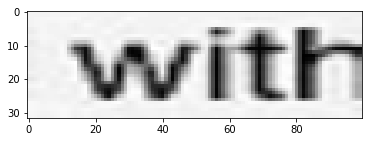

with



In [135]:
gen = training_generator(1, len(vocab))
x,y = next(gen)
plt.imshow(x[0,:,:,0], cmap='gray')
plt.show()
print(vocab[np.argmax(y[0])])

['train_data', 'valid_data', 'valid_label', 'train_label']


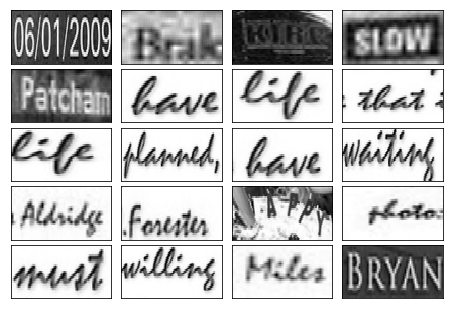

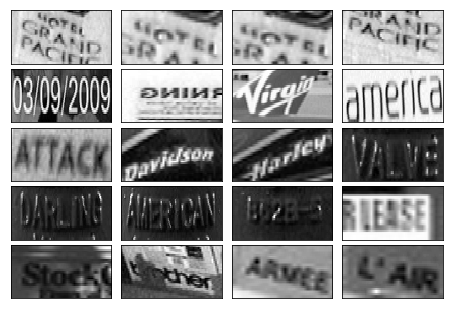

In [7]:
npzfile = np.load('words.npz')
print (npzfile.files)
train_data = npzfile['train_data']
train_label= npzfile['train_label']
valid_dat= npzfile['valid_data']
valid_label = npzfile['valid_label']


gs = gridspec.GridSpec(min(5,int(len(train_data)/4)),4, top=1., bottom=0., right=1., left=0., hspace=0.1, wspace=0.1)
    
for i,g in enumerate(gs): 
    ax = plt.subplot(g)
    ax.imshow(train_data[i,:,:,0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
plt.show()

for i,g in enumerate(gs): 
    ax = plt.subplot(g)
    ax.imshow(valid_data[i,:,:,0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
plt.show()